#[START](#start)

#[data](#data)
* [datasetting](#datasetting)

#[model](#model)
* [modelsetting](#modelsetting)

get file from other drive file

#測試區

In [ ]:
## read target video target frame
# start = time.time()

%timeit -n 10 for num in range(1,101):img = read_video_as_image(file_url, num)
# end = time.time()
# print(f'{(end - start):.5f}s per 100 pics by target video and frame')

#read by cv2
%timeit -n 10 for num in range(1,101):img = Image.fromarray(cv2.imread(f'/content/image/{num}.jpg'))


#read by PIL
%timeit -n 10  for num in range(1,101):img = Image.open(f'/content/image/{num}.jpg')

#y1: 先解壓縮然後load圖片會花的時間
#y2: 直接讀特定frame花的時間
total_pics = 1008463
training_epoch = 6
x = range(total_pics * training_epoch)
y1 = [(nums*(1/1400*180 + 1/100*0.008) if nums<total_pics else total_pics*180/1400 + nums/100*0.008) for nums in x]
y2 = [nums/100*4 for nums in x]
plt.plot(x, y1)
plt.plot(x, y2) del x, y1, y2

10 loops, best of 3: 3.98 s per loop
10 loops, best of 3: 348 ms per loop
10 loops, best of 3: 7.89 ms per loop


In [ ]:
# custom is much faster than pytorch transform
a_np = np.zeros((640,440,3))
a_pil = Image.fromarray(np.uint8(np.zeros((640,440,3))))
totensor = transforms.ToTensor()
resizer = transforms.Resize(256)
randomcroper = transforms.RandomCrop(224)
def custom_resize(image):
  output_size = 256
  h, w = image.shape[:2]
  if h > w:
    new_h, new_w = int(h * output_size / w), output_size
  else:
    new_h, new_w = output_size, int(w * output_size / h)
  return cv2.resize(image, dsize=(new_w, new_h))

def custom_randomcrop(image):
  h, w = image.shape[:2]
  new_h, new_w = 256, 256
  top = np.random.randint(0, h - new_h)
  left = np.random.randint(0, w - new_w)

  return image[top: top + new_h,
                left: left + new_w]
print('ToTensor')
%timeit -n 10 totensor(a_pil)
%timeit -n 10 totensor(a_np) 
%timeit -n 10 torch.from_numpy(a_np)
print('resizer')
%timeit -n 10 resizer(a_pil)
%timeit -n 10 custom_resize(a_np)
print('randomCrop')
%timeit -n 10 randomcroper(a_pil)
%timeit -n 10 custom_randomcrop(a_np)

ToTensor
10 loops, best of 5: 2.55 ms per loop
10 loops, best of 5: 1.94 ms per loop
10 loops, best of 5: 1.75 µs per loop
resizer
10 loops, best of 5: 3.21 ms per loop
10 loops, best of 5: 1.55 ms per loop
randomCrop
10 loops, best of 5: 33.1 µs per loop
10 loops, best of 5: 7.52 µs per loop


#START
<a name='start'>Pipeline Start From Here</a>
<p><a name='data'><font size=4>1. dataing</font></a></p>

In [ ]:
#@title
%cd .. 
!du -shc

/
du: cannot read directory './proc/115/task/115/net': Invalid argument
du: cannot read directory './proc/115/net': Invalid argument
du: cannot read directory './proc/173/task/173/net': Invalid argument
du: cannot read directory './proc/173/net': Invalid argument
du: cannot read directory './proc/225/task/225/net': Invalid argument
du: cannot read directory './proc/225/net': Invalid argument
du: cannot read directory './proc/639/task/639/net': Invalid argument
du: cannot read directory './proc/639/net': Invalid argument
du: cannot read directory './proc/641/task/641/net': Invalid argument
du: cannot read directory './proc/641/net': Invalid argument
du: cannot read directory './proc/643/task/643/net': Invalid argument
du: cannot read directory './proc/643/net': Invalid argument
du: cannot access './proc/786/task/786/fd/4': No such file or directory
du: cannot access './proc/786/task/786/fdinfo/4': No such file or directory
du: cannot access './proc/786/fd/3': No such file or directory
d

In [ ]:
!pip install livelossplot

# !pip install wandb
# import wandb
# wandb.init()

from livelossplot import PlotLosses
import tarfile
import os
import shutil
import random

from PIL import Image
import cv2  
import math
import re
import skimage.transform #io, transform
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
from torch import optim
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

import time
from tqdm import tqdm

def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
seed_torch()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

def get_files_path(folder_url):
    return [os.path.join(root, file) for root, _, files in os.walk(folder_url) for file in files] 

def get_sorted_folder_path(url):
    urls = get_files_path(url)
    urls.sort(key=lambda x: list(map(int, re.findall('\d+', x))))
    return urls

def tar_file(file_url):
    start = time.time()
    with tarfile.open(file_url) as file:
        file.extractall(os.path.dirname(file_url),)
        print(f'done! time: {time.time() - start}')

def get_data(file_url):
    with open(file_url) as file:
        output = [elem.strip() for elem in file.readlines()]
    return output

def get_data_to_numpy(file_url):
    with open(file_url) as file:
        output = np.fromfile(file)
    return output

def get_frame_nums(index):
    return (len(list(os.walk(f'/content/aff_wild_annotations_bboxes_landmarks_new/landmarks/train/{index}/'))[0][2]),
            len(list(os.walk(f'/content/aff_wild_annotations_bboxes_landmarks_new/bboxes/train/{index}/'))[0][2]))

def show_landmark_and_bbox(image, landmarks, bboxes):
    """
    Show image with landmarks
    landmarks: N images * (x, y)
    """
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    for i in range(4):
        if i<3:
            plt.plot([bboxes[i][0], bboxes[i+1][0]], [bboxes[i][1], bboxes[i+1][1]])
        else:
            plt.plot([bboxes[i][0], bboxes[0][0]], [bboxes[i][1], bboxes[0][1]])
    plt.pause(0.001)  # pause a bit so that plots are updated
    
#images
def read_video_as_image(file_url, frame_idx):
    cap = cv2.VideoCapture(file_url)   # capturing the video from the given path
    cap.set(1, frame_idx) #current frame number
    success, frame = cap.read()
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if success else np.zeros((224,224,3))
    cap.release()
    # return Image.fromarray(np.uint8(rgb_img)) #use custom transform
    return np.uint8(rgb_img)

def show_image(img):
    plt.figure()
    plt.imshow(img)
    plt.show

def ç(file_url, pic_nums):
    cap = cv2.VideoCapture(file_url)   # capturing the video from the given path
    frame_rate = cap.get(5)
    success, frame = cap.read()
    count = 0
    while cap.isOpened() and count<pic_nums:
        if not success:
            break
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        show_image(rgb_img)
        cap.set(1, cap.get(1)+frame_rate) #current frame number
        count += 1        
    cap.release()

def read_video_and_save(file_url, target_path, frame_rate=100):
    cap = cv2.VideoCapture(file_url)   # capturing the video from the given path
    video_index = re.search('\d+',file_url).group()
    print(video_index)
    success, frame = cap.read()
    if os.path.exists(target_path):
        os.chdir(target_path)
    else:
        os.mkdir(target_path)
    current_frame_num = cap.get(1)
    total_frame_num = cap.get(7)
    while cap.isOpened() and current_frame_num < total_frame_num - 50:
        if not success:
            break
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cap.set(1, cap.get(1)+frame_rate) #current frame number
        cv2.imwrite(f'video{video_index}frame{current_frame_num}.jpg', rgb_img)
    cap.release()
    print(f'{video_index} video done!')


def torchvision_read_video(path):
    """package問題"""
    torchvision.io.read_video(path)

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        print(s)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

def remove_folder(path):
    shutil.rmtree(path)

In [ ]:
root = '/content/aff_wild_annotations_bboxes_landmarks_new/videos/train'
for file in os.listdir(root):
    path = os.path.join(root, file)
    read_video_and_save(path, '/content/pics')

224


In [ ]:
def get_raw_data():
    # only first time
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    downloaded = drive.CreateFile({'id':"1A6uU4XdO11o_VYSV5RCGiwCb9l4Wgk4s"}) 
    downloaded.GetContentFile('aff_wild_videos_annotations_bboxes_landmarks.tar.gz')
    downloaded.Upload()

    tar_file('/content/aff_wild_videos_annotations_bboxes_landmarks.tar.gz')

    src = '/content/aff_wild_annotations_bboxes_landmarks_new'
    dst = '/content/gdrive/MyDrive/SideProject/aff_wild_annotations_bboxes_landmarks_new'
    shutil.move(src, dst)

def data_prep(copy = True, tar = True):
    if copy:
        src = '/content/gdrive/MyDrive/SideProject/aff_wild_annotations_bboxes_landmarks_new'
        dst = '/content/aff_wild_annotations_bboxes_landmarks_new'    
        try:
            copytree(src, dst)
        except:
            pass

    # 解壓縮
    if tar:
        tarfiles = get_files_path('/content/aff_wild_annotations_bboxes_landmarks_new')
        for path in tarfiles:
            tar_file(path)                        

# get_raw_data()        
data_prep(True, True)

/content/gdrive/MyDrive/SideProject/aff_wild_annotations_bboxes_landmarks_new/annotations
/content/gdrive/MyDrive/SideProject/aff_wild_annotations_bboxes_landmarks_new/bboxes
/content/gdrive/MyDrive/SideProject/aff_wild_annotations_bboxes_landmarks_new/videos
/content/gdrive/MyDrive/SideProject/aff_wild_annotations_bboxes_landmarks_new/landmarks
done! time: 142.20143365859985
done! time: 26.673814058303833
done! time: 215.93202900886536
done! time: 45.32514190673828
done! time: 0.17513012886047363
done! time: 203.60403680801392
done! time: 41.7488317489624


Try multiprocess/multithread

In [ ]:
#@title
# # multi...
# os.mkdir('aff_wild_annotations_bboxes_landmarks_new')
# from multiprocessing import Pool, cpu_count
# import threading

# def copy_file(src_dst):
#     print('start')
#     print(src_dst)
#     copytree(src_dst[0], src_dst[1])

# dst = '/content/gdrive/MyDrive/SideProject/aff_wild_annotations_bboxes_landmarks_new'
# src = '/content/aff_wild_annotations_bboxes_landmarks_new'
# srcs = [os.path.join(src, folder) for folder in os.listdir(src)]
# dsts = [os.path.join(dst, folder) for folder in os.listdir(src)]
# srcs_dsts = list(zip(srcs, dsts))

# def multiprocess_copy_file(srcs_dsts):
#     start = time.time()
#     with Pool(cpu_count()) as p:
#         p.map(copy_file, srcs_dsts)
#     print(time.time() - start)
#     #179.6968069076538

# def multithread_copy_file(srcs_dsts):
#     start = time.time()
#     threads = []
#     for i, src_dst in enumerate(srcs_dsts):
#         threads.append(threading.Thread(target = copy_file, args = ( src_dst,)))
#         threads[i].start()

#     for i in range(4):
#         threads[i].join()
#     print(time.time() - start)

# def multiprocess_tar_file(paths):
#     start = time.time()
#     with Pool(cpu_count()) as p:
#         p.map(tar_file, paths)
#     print(time.time() - start)
#     #179.6968069076538

# tarfiles = get_files_path('/content/aff_wild_annotations_bboxes_landmarks_new')
# multiprocess_tar_file(tarfiles)

#DATASET

In [ ]:
# custom data loader
# from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, phase='train', frame_rate=100, require_landmark=True):
        """
        input format
        dtype: numpy.float
        [imgs, annotations(v, a), bboxes, landmarks]
        """   
        assert root_dir == '/content/aff_wild_annotations_bboxes_landmarks_new'
        
        self.root_dir = root_dir
        self.frame_rate = frame_rate if phase == 'train' else frame_rate*2 
        self.transform = transform
        self._phase = phase
        self._require_landmark = require_landmark
        
        sorted_path = get_sorted_folder_path(os.path.join(root_dir, 'annotations/train'))
        if phase == 'train':
            sorted_path = sorted_path[:370] 
        elif phase == 'small':
            sorted_path = sorted_path[12:14]
        else: 
            sorted_path = sorted_path[370:]

        annotations_a = [get_data(url) for url in sorted_path[::2]]
        annotations_v = [get_data(url) for url in sorted_path[1::2]]
        # self.annotations = [[image_index, frame_index, valence, arouse], [...]]

        annotations = np.array([[re.search('\d+', sorted_path[::2][num]).group(), frmidx, annotations_v[num][frmidx], annotations_a[num][frmidx]] 
                                for num, img in enumerate(annotations_a) 
                                for frmidx in range(50, len(img)-50)], dtype=np.float16) #-50代表後50個frame不取
        
        annotations = annotations[(annotations[:,2:] != 0).any(axis = 1)] # 篩選掉 valence and arousal == 0
        self.annotations = annotations[::self.frame_rate] #以self.frame_rate 取樣
        self._len = self.annotations.shape[0]

        del sorted_path, annotations_a, annotations_v, annotations

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        assert isinstance(idx, (int, list)), '必須是int or list'

        image_index = int(self.annotations[idx][0])
        frame_index = int(self.annotations[idx][1])
        sub_file_name = '.avi' if image_index <= 200 else '.mp4'
        
        image_url = os.path.join(self.root_dir, f'videos/train/{image_index}{sub_file_name}')
        bboxes_url = os.path.join(self.root_dir, f'bboxes/train/{image_index}/{frame_index}.pts')
        landmarks_url = os.path.join(self.root_dir, f'landmarks/train/{image_index}/{frame_index}.pts')
        
        image = read_video_as_image(image_url, frame_index)
        sample = {
            'image': image,
            'annotations': self.annotations[idx][2:],
            'bboxes': self.get_bboxes_or_landmarks_data(bboxes_url) if os.path.exists(bboxes_url) else np.zeros((4,2), dtype=np.int8),
            'landmarks': self.get_bboxes_or_landmarks_data(landmarks_url) if os.path.exists(landmarks_url) and self._require_landmark else np.zeros((68,2), dtype=np.int8)
        } if image.mean() > 30 else {
            'image': image,
            'annotations': np.zeros((2), dtype=np.int8),
            'bboxes': np.zeros((4, 2), dtype=np.int8),
            'landmarks': np.zeros((68, 2), dtype=np.int8)
        }
        # bboxes = sample['bboxes']
        # landmarks = sample['landmarks']
    
        # print(f'img: {image.mean()}, box: {bboxes.mean()}, lm: {landmarks.mean(), landmarks.shape}, annotations: {self.annotations.mean}')
        if self.transform:      
            sample = self.transform(sample)
        return sample

    def get_bboxes_or_landmarks_data(self, url):
            data = [elem.split(' ') for elem in get_data(url)[3:-1]]
            return np.array(data).astype(np.float16)


# from torchvision import transforms, utils
class Rescale():
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)), '必須是 int or tuple'
        self.output_size = output_size
    
    def __call__(self, sample):
        image, bboxes, landmarks = sample['image'], sample['bboxes'], sample['landmarks']
        if image.mean() == 0: #讀取影片失敗會得到 np.zeros((224, 224, 3))
            pass
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = int(h * self.output_size / w), self.output_size
            else:
                new_h, new_w = self.output_size, int(w * self.output_size / h)
        else:
            new_h, new_w = self.output_size
        
        image = cv2.resize(image, dsize=(new_w, new_h))
        if (landmarks[0]!=0).any():
            landmarks = (landmarks * [new_w/w, new_h/h]).astype(np.int16)
        if (bboxes[0]!=0).any():
            bboxes = (bboxes * [new_w/w, new_h/h]).astype(np.int16)
        return {
            'image': image,
            'annotations': sample['annotations'],
            'bboxes': bboxes,
            'landmarks': landmarks
            }

class TargetRandomCrop(object):
    """Center Crop the image without cropping target hard.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, bboxes, landmarks, annotations = sample['image'], sample['bboxes'], sample['landmarks'], sample['annotations']
        if image.mean() == 0: #讀取影片失敗會得到 np.zeros((224, 224, 3))
            pass
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        max_left = w - new_w
        max_top = h - new_h
        
        if (bboxes[0]!=0).any():
            box_left, box_top = bboxes[0]
            if box_left < max_left:
                max_left = box_left
            if box_top < max_top:
                max_top = box_top
            left = np.random.randint(max_left*0.65, max_left+1)
            top = np.random.randint(max_top*0.65, max_top+1)
            bboxes = bboxes - [left, top]

        else:
            top = max_top
            left = max_left
           
        image = image[top: top + new_h,
                        left: left + new_w]
        
        if (landmarks[0]!=0).any():
            landmarks = landmarks - [left, top]

        return {
            'image': image,
            'annotations': annotations,
            'bboxes': bboxes,
            'landmarks': landmarks
            }


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bboxes, landmarks, annotations = sample['image'], sample['bboxes'], sample['landmarks'], sample['annotations']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'annotations': torch.from_numpy(annotations).float(),
                'bboxes': torch.from_numpy(bboxes).float(),
                'landmarks': torch.from_numpy(landmarks).float()
                }

#Dataset Setting
<p><a name='datasetting'><font size=4>1. datasetting</font></a></p>

In [ ]:
class DataConfig(object):
    root_dir = '/content/aff_wild_annotations_bboxes_landmarks_new'
    batch_size = 64 # batch size
    use_gpu = True # use GPU or not
    num_workers = 2 # how many workers for loading data
    pin_memory = True
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dconfig = DataConfig()


def get_dataset_dataloader(phase):
    shuffle_dict = { 'train': True, 
                    'valid': False, 
                    'small': False }

    composed_transforms = transforms.Compose([
                                          Rescale(280),
                                          TargetRandomCrop(224),
                                          ToTensor()
                                        ])
    dataset = CustomDataset(dconfig.root_dir, transform=composed_transforms, phase=phase)
    dataloader = DataLoader(
        dataset,
        batch_size = dconfig.batch_size,
        shuffle = shuffle_dict[phase],
        num_workers = dconfig.num_workers,
        pin_memory = dconfig.pin_memory
    )
    return dataset, dataloader

train_dataset, train_dataloader = get_dataset_dataloader('train')
valid_dataset, valid_dataloader = get_dataset_dataloader('valid')

# for dataset in [small_dataset, train_dataset, valid_dataset]:
#     print(len(dataset))

In [ ]:
for ds in [train_dataset, valid_dataset]:
    print(len(ds))

7558
1083


#MODEL
<a name='model'><font size=4>2. modeling</font></a>

1. super是必須的, 不然會出錯

In [ ]:
def make_model(model_size, pretrained=True):
    model_dict = {18: models.resnet18,
                  34: models.resnet34,
                  50: models.resnet50,
                  101: models.resnet101,
                  152: models.resnet152 }
    model = model_dict[model_size](pretrained=pretrained)
    num_fts = model.fc.in_features
    if pretrained:
        for param in model.parameters():
            param._require_grads = False
    model.fc = nn.Linear(num_fts, 2)
    
    # summary(model, (3,224,224))
    return model

In [ ]:
#save_and_load_model
def save_loss_as_txt(loss_dict, folder_path):
    """
    loss_dict: {'train': [], 'valid': [], epoch: [], time: []}
    """
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    file_path = os.path.join(folder_path, mconfig.model_name + '.txt')
    with open(file_path, 'a+') as file:
        file.write('epoch, train loss, valid loss, time\n')
        for t, v, e, time in zip(loss_dict['train'], loss_dict['valid'], loss_dict['epoch'], loss_dict['time']):
            file.write(f'{e}, {t}, {v}, {time}\n')

def save_model(PATH):
    torch.save(model.state_dict(), PATH)

def load_model(PATH):
    model.load_state_dict(torch.load(PATH))
    model.eval()

def save_general_checkpoint(PATH, epoch):
    folder_path = os.path.dirname(PATH)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.cpu().state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,            
            }, PATH)

def load_general_checkpoint(PATH):
    checkpoint = torch.load(PATH, map_location=dconfig.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(dconfig.device)
    for model_params, optim_params in optimizer.state.items():
        for k, v in optim_params.items():
            if isinstance(v, torch.Tensor):
                optim_params[k] = v.to(dconfig.device)


    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    # model.eval()
    model.train()
    return model, optimizer, epoch, loss


#Model Setting
<p><a name='modelsetting'><font size=4>1. modelsetting</font></a></p>

In [ ]:
class ModelConfig:
    model_root_folder = '/content/gdrive/MyDrive/SideProject/model/'
    loss_graph_root_folder = '/content/gdrive/MyDrive/SideProject/loss_graph/'
    
    model_name = 'res34_bsize64_adam'
    resnet_size = 34
    pretrained = True
    model_name_suffix = 'epoch12' #only needed when load model
    print_freq = len(train_dataset)/dconfig.batch_size/4 # print info every N batch
    save_freq = 4
    max_epoch = 20
    lr = 0.001 # initial learning rate
    lr_decay = 0.95 # when val_loss increase, lr = lr*lr_decay
    weight_decay = 1e-4 # 损失函数

    model_save_folder = os.path.join(model_root_folder, model_name)
    target_model_path = os.path.join(model_save_folder , model_name_suffix)
    loss_graph_folder_path = os.path.join(loss_graph_root_folder, model_name)


mconfig = ModelConfig()   
model = make_model(mconfig.resnet_size, pretrained=mconfig.pretrained)
loss = nn.MSELoss()
optimizer = optim.Adam(model.fc.parameters())
last_epoch = 0
writer = SummaryWriter(log_dir=mconfig.loss_graph_folder_path, filename_suffix=mconfig.model_name)
plotlosses = PlotLosses()
model, optimizer, last_epoch, loss = load_general_checkpoint(mconfig.target_model_path)

In [ ]:
def train_model(train_iter, valid_iter, model, loss, optimizer, start_epoch):
    model.to(dconfig.device).float()
    loss_dict = {'train': [], 'valid': [], 'epoch': [], 'time': []}

    for epoch in range(mconfig.max_epoch):
        start = time.time()
        now_epoch = epoch + start_epoch

        for phase, data_iter in [('train', train_iter), ('valid', valid_iter)]:
            l, epoch_loss, n, batch_count = 0.0, 0.0, 0, 0
            print(f'{phase}{now_epoch} start!')
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            for sample in data_iter:
                X, y = sample['image'].float().to(dconfig.device), sample['annotations'].float().to(dconfig.device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    y_hat = model(X)
                    l = loss(y_hat, y)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        l.backward()
                        optimizer.step()

                epoch_loss += l.detach().cpu().item()
                n += dconfig.batch_size
                batch_count += 1 

                if batch_count % mconfig.print_freq == 0:
                    print(f'{batch_count} batch, time: {time.time() - start}')

            epoch_loss = epoch_loss * n / batch_count
            loss_dict[phase].append(epoch_loss)
                

        loss_dict['epoch'].append(now_epoch)
        loss_dict['time'].append(time.time() - start)
        writer.add_scalar(mconfig.model_name+"_Loss/train", loss_dict['train'][-1], now_epoch)
        writer.add_scalar(mconfig.model_name+"_Loss/valid", loss_dict['valid'][-1], now_epoch)
        writer.flush()

        plotlosses.update({'loss': loss_dict['train'][-1], 'val_loss': loss_dict['valid'][-1]})        
        plotlosses.send()
        
        print(f'epoch: {now_epoch}, train_loss: {loss_dict["train"][-1]:.4f}, test_loss: {loss_dict["valid"][-1]:.4f}, epoch_time: {time.time() - start:.1f} sec')
        
        if now_epoch % mconfig.save_freq == 0:
            filename =  'epoch' + str(now_epoch)
            PATH = os.path.join(mconfig.model_save_folder, filename)
            save_general_checkpoint(PATH, now_epoch)
            save_loss_as_txt(loss_dict, mconfig.model_save_folder)
            model.to(dconfig.device)
            loss_dict = {'train': [], 'valid': [], 'epoch': [], 'time': []}

In [ ]:
print(train_dataloader.batch_size, optimizer, loss)
train_model(train_dataloader, valid_dataloader, model, loss, optimizer, start_epoch=last_epoch+1)
#pretrained_resnet34_bsize64_adam

64 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
) MSELoss()
train13 start!


In [ ]:
!tensorboard dev upload --logdir test \
--name "My latest experiment" \
--description "Simple comparison of several hyperparameters"

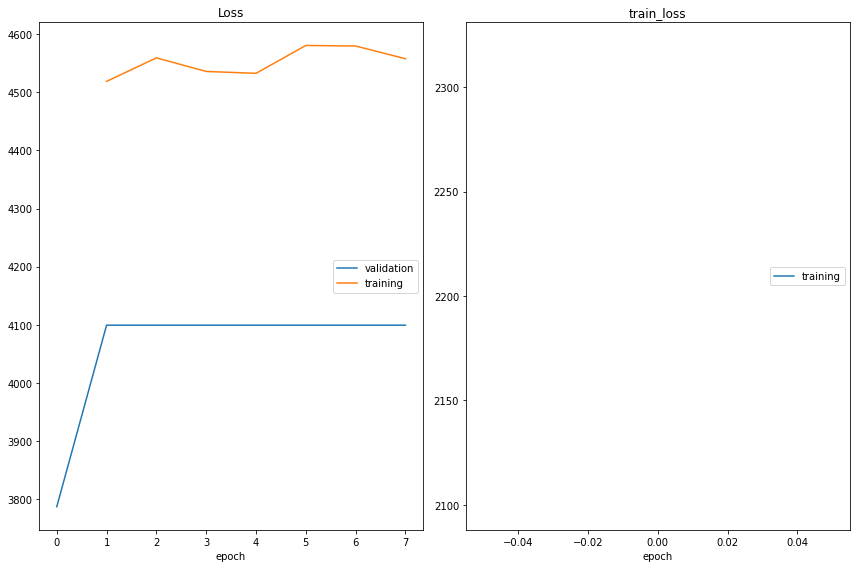

Loss
	validation       	 (min: 3787.080, max: 4099.358, cur: 4099.358)
	training         	 (min: 4518.642, max: 4580.432, cur: 4557.609)
train_loss
	training         	 (min: 2209.567, max: 2209.567, cur: 2209.567)
epoch: 6, train_loss: 4557.6095, test_loss: 4099.3580, epoch_time: 2547.3 sec
train7 start!
1000 batch, time: 628.7625780105591
valid7 start!
1000 batch, time: 1949.7109158039093
epoch: 7, train_loss: 4458.9742, test_loss: 4099.3580, epoch_time: 2583.2 sec
train8 start!
1000 batch, time: 633.287703037262
valid8 start!
1000 batch, time: 1949.9265983104706


KeyboardInterrupt: ignored

In [ ]:
# model = make_model(18, pretrained=True)
#對照組
# 1. model:
#    1.1 pretrained=False 
#    1.2 bigmodel
# 2. loss
#    2.1 smoothL1
#    2.2 
# 3. optimizer 
# 


In [ ]:
# grad_cam
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())


def farward_hook(module, input, output):
    fmap_block.append(output)

def comp_class_vec(output_vec, index=None):
    """
    计算类向量
    :param ouput_vec: tensor
    :param index: int，指定类别
    :return: tensor
    """
    print(output_vec)
    if not index:
        index = np.argmax(output_vec.cpu().data.numpy())
    else:
        index = np.array(index)
    print(index)
    index = index[np.newaxis, np.newaxis]
    print(index)
    index = torch.from_numpy(index)
    print(index)
    one_hot = torch.ones(1, 2).scatter_(1, index, 1).to(dconfig.device)
    one_hot.requires_grad = True
    print(one_hot)
    class_vec = torch.sum(one_hot * output)  # one_hot = 11.8605
    print(class_vec)
    return class_vec

def gen_cam(feature_map, grads):
    """
    依据梯度和特征图，生成cam
    :param feature_map: np.array， in [C, H, W]
    :param grads: np.array， in [C, H, W]
    :return: np.array, [H, W]
    """
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)  # cam shape (H, W)

    weights = np.mean(grads, axis=(1, 2))  #
    print(f'weights.shape: {weights.shape}, cam.shape: {cam.shape}')
    # feature_map = np.mean(feature_map, axis=0)
    print(f'feature_map.shape: {feature_map.shape}')
    for i, w in enumerate(weights):
        # print(w, cam.shape)
        cam += w * feature_map[i, :, :]

    # cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (32, 32))
    cam -= np.min(cam)
    cam /= np.max(cam)

    return cam

def show_cam_on_image(img, mask, out_dir):
    heatmap = cv2.applyColorMap((255*mask).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    print(f'heatmap: {heatmap.shape}, img: {img.shape}')
    cam = cv2.addWeighted(np.float32(img),0.6,heatmap,0.4,0)
    cam = cam / np.max(cam)

    path_cam_img = os.path.join(out_dir, "cam.jpg")
    path_raw_img = os.path.join(out_dir, "raw.jpg")
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    cv2.imwrite(path_cam_img, np.uint8(255 * cam))
    cv2.imwrite(path_raw_img, np.uint8(255 * img))


# def main_grad_cam(net, img_input):
imgs = None
labels = None
for sample in train_dataloader:
    imgs = sample['image']
    labels = sample['annotations']
    break

fmap_block = []
grad_block = []

net = model.to(dconfig.device).double()
img_input = imgs[0].unsqueeze(dim=0).to(dconfig.device)
print(f'img_input: {img_input.shape}')
# 注册hook
output_dir = '/content/gdrive/MyDrive/SideProject/grad_cam'

net.layer4[1].register_forward_hook(farward_hook)
net.layer4[1].register_backward_hook(backward_hook)

# forward
output = net(img_input)
print(f'output: {output}')
# idx = np.argmax(output.cpu().data.numpy())
# print("predict: {}".format(classes[idx]))

# backward
net.zero_grad()
# _loss = comp_class_vec(output)
# _loss = loss(output, labels[7].to(dconfig.device))
_loss = output.sum()
print(f'loss: {_loss}')
_loss.backward()

# 生成cam
grads_val = grad_block[0].cpu().data.numpy().squeeze()
fmap = fmap_block[0].cpu().data.numpy().squeeze()
print(f'grads_val: {grads_val.shape}, fmap: {fmap.shape}')
cam = gen_cam(fmap, grads_val)
print(f'cam: {cam.shape}')
# 保存cam图片
img = img_input.numpy()[::1-,:,:]
img_show = np.float32(cv2.resize(img, (32, 32))) / 255
print(f'img_show: {img_show.shape}')
show_cam_on_image(img_show, cam.astype(np.uint8), output_dir)